In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [23]:
train = pd.read_csv("D:\data\movies_reviews\\train.tsv", sep="\t")
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [24]:
train = train[["Phrase", "Sentiment"]]
train['Phrase'] = train['Phrase'].apply(lambda x: x.lower())
train

c:\users\nghia\environments\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Phrase,Sentiment
0,a series of escapades demonstrating the adage ...,1
1,a series of escapades demonstrating the adage ...,2
2,a series,2
3,a,2
4,series,2
5,of escapades demonstrating the adage that what...,2
6,of,2
7,escapades demonstrating the adage that what is...,2
8,escapades,2
9,demonstrating the adage that what is good for ...,2


In [26]:
train["Sentiment"].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [27]:
lens = []
for idx, row in train.iterrows():
    lens.append(len(row["Phrase"]))
lens

[188,
 77,
 8,
 1,
 6,
 68,
 2,
 65,
 9,
 55,
 23,
 13,
 9,
 3,
 5,
 31,
 4,
 26,
 4,
 21,
 2,
 18,
 4,
 13,
 3,
 9,
 5,
 110,
 108,
 7,
 4,
 100,
 95,
 91,
 12,
 10,
 6,
 1,
 78,
 13,
 4,
 8,
 5,
 64,
 12,
 51,
 6,
 44,
 3,
 40,
 4,
 35,
 32,
 26,
 7,
 18,
 2,
 15,
 4,
 10,
 7,
 5,
 1,
 74,
 55,
 4,
 50,
 38,
 5,
 32,
 30,
 17,
 13,
 3,
 12,
 11,
 18,
 16,
 8,
 5,
 7,
 100,
 36,
 9,
 4,
 4,
 26,
 23,
 18,
 6,
 11,
 8,
 2,
 4,
 63,
 13,
 11,
 9,
 1,
 7,
 49,
 47,
 5,
 41,
 4,
 36,
 11,
 9,
 4,
 4,
 24,
 7,
 16,
 7,
 8,
 3,
 152,
 150,
 101,
 34,
 32,
 10,
 21,
 9,
 11,
 66,
 63,
 15,
 11,
 47,
 3,
 43,
 39,
 8,
 30,
 28,
 8,
 19,
 17,
 10,
 6,
 6,
 48,
 45,
 26,
 23,
 21,
 13,
 7,
 2,
 18,
 16,
 5,
 10,
 4,
 5,
 60,
 58,
 10,
 47,
 22,
 18,
 24,
 22,
 12,
 9,
 124,
 41,
 14,
 12,
 26,
 23,
 11,
 6,
 4,
 11,
 82,
 80,
 31,
 6,
 24,
 2,
 21,
 19,
 7,
 11,
 48,
 2,
 45,
 19,
 15,
 5,
 9,
 25,
 10,
 14,
 7,
 6,
 52,
 11,
 40,
 38,
 17,
 7,
 9,
 5,
 3,
 20,
 18,
 15,
 13,
 8,
 4,
 112,
 14,

c:\users\nghia\environments\tf-gpu\lib\site-packages\matplotlib\axes\_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0.0, 8890.0)

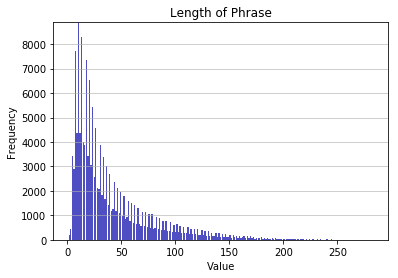

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=lens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Length of Phrase')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [49]:
max_fatures = 100
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train['Phrase'].values)
X = tokenizer.texts_to_sequences(train['Phrase'].values)
X = pad_sequences(X)
X

array([[ 0,  0,  0, ...,  3,  2, 42],
       [ 0,  0,  0, ..., 46, 13,  1],
       [ 0,  0,  0, ...,  0,  0,  2],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [50]:
X.shape[1]

30

In [33]:
####### BUILD model ##########
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 128)           12800     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 985       
Total params: 268,585
Trainable params: 268,585
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
####### convert to 1-hot vector #######
Y = pd.get_dummies(train['Sentiment']).values
Y

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(104560, 30) (104560, 5)
(51500, 30) (51500, 5)


In [38]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 1)

Epoch 1/7
104560/104560 [==============================] - 267s 3ms/step - loss: 1.1846 - acc: 0.5357
Epoch 2/7
104560/104560 [==============================] - 227s 2ms/step - loss: 1.1767 - acc: 0.5381
Epoch 3/7
104560/104560 [==============================] - 224s 2ms/step - loss: 1.1702 - acc: 0.5419
Epoch 4/7
104560/104560 [==============================] - 228s 2ms/step - loss: 1.1662 - acc: 0.5436
Epoch 5/7
104560/104560 [==============================] - 236s 2ms/step - loss: 1.1600 - acc: 0.5451
Epoch 6/7
104560/104560 [==============================] - 229s 2ms/step - loss: 1.1529 - acc: 0.5488
Epoch 7/7
104560/104560 [==============================] - 225s 2ms/step - loss: 1.1435 - acc: 0.5547 0s - loss: 1.1435 - acc: 0.5


In [65]:
test = pd.read_csv("D:\data\movies_reviews\\test.tsv", sep="\t")
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [66]:
test = test[["PhraseId", "Phrase"]]
test['Phrase'] = test['Phrase'].apply(lambda x: x.lower())
test

,PhraseId,Phrase
0,156061,an intermittently pleasing but mostly routine ...
1,156062,an intermittently pleasing but mostly routine ...
2,156063,an
3,156064,intermittently pleasing but mostly routine effort
4,156065,intermittently pleasing but mostly routine
5,156066,intermittently pleasing but
6,156067,intermittently pleasing
7,156068,intermittently
8,156069,pleasing
9,156070,but


In [57]:
X_test = tokenizer.texts_to_sequences(test['Phrase'].values)
X_test = pad_sequences(X_test, maxlen=X.shape[1])

In [59]:
X_test.shape

(66292, 30)

In [61]:
result = model.predict(X_test, batch_size=32, verbose=1)

66292/66292 [==============================] - 64s 967us/step


In [62]:
result

array([[0.00690174, 0.2014602 , 0.5233483 , 0.259251  , 0.00903881],
       [0.00690174, 0.2014602 , 0.5233483 , 0.259251  , 0.00903881],
       [0.02916227, 0.12586157, 0.46928945, 0.29753608, 0.07815056],
       ...,
       [0.02117437, 0.12293683, 0.5814081 , 0.22314556, 0.05133512],
       [0.02117437, 0.12293683, 0.5814081 , 0.22314556, 0.05133512],
       [0.01903232, 0.13109483, 0.66615635, 0.15762158, 0.02609488]],
      dtype=float32)

In [64]:
predictions = [np.argmax(line) for line in result]
predictions

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [67]:
res = pd.DataFrame({"PhraseId": test["PhraseId"], "Sentiment": predictions})

In [68]:
res.to_csv("submission.csv", index=False)

In [70]:
model.save("model_7epochs.h5")